In [0]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

from torch.utils.data import DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
from torchvision import datasets, transforms
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

In [0]:
mnist_transform = transforms.Compose([
                transforms.ToTensor(),
                transforms.Normalize((0.1307,), (0.3081,)),
           ])

def mnist(batch_size=50, valid=0, shuffle=True, transform=mnist_transform, path='./MNIST_data'):
    test_data = datasets.MNIST(path, train=False, download=True, transform=transform)
    test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)
    
    train_data = datasets.MNIST(path, train=True, download=True, transform=transform)
    train_data.data = train_data.data[:1000,:,:]
    if valid > 0:
        num_train = len(train_data)
        indices = list(range(num_train))
        split = num_train-valid
        np.random.shuffle(indices)

        train_idx, valid_idx = indices[:split], indices[split:]
        train_sampler = SubsetRandomSampler(train_idx)
        valid_sampler = SubsetRandomSampler(valid_idx)

        train_loader = DataLoader(train_data, batch_size=batch_size, sampler=train_sampler)
        valid_loader = DataLoader(train_data, batch_size=batch_size, sampler=valid_sampler)
    
        return train_loader, valid_loader, test_loader
    else:
        train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=shuffle)
        return train_loader, test_loader


def plot_mnist(images, shape):
    fig = plt.figure(figsize=shape[::-1], dpi=80)
    for j in range(1, len(images) + 1):
        ax = fig.add_subplot(shape[0], shape[1], j)
        ax.matshow(images[j - 1, 0, :, :], cmap = matplotlib.cm.binary)
        plt.xticks(np.array([]))
        plt.yticks(np.array([]))
    plt.show()
    
def plot_graphs(log, tpe='loss'):
    keys = log.keys()
    logs = {k:[z for z in zip(*log[k])] for k in keys}
    epochs = {k:range(len(log[k])) for k in keys}
    
    if tpe == 'loss':
        handlers, = zip(*[plt.plot(epochs[k], logs[k][0], label=k) for k in keys])
        plt.title('errors')
        plt.xlabel('epoch')
        plt.ylabel('error')
        plt.legend(handles=handlers)
        plt.grid()
        plt.show()
    elif tpe == 'accuracy':
        handlers, = zip(*[plt.plot(epochs[k], logs[k][1], label=k) for k in log.keys()])
        plt.title('accuracy')
        plt.xlabel('epoch')
        plt.ylabel('accuracy')
        plt.legend(handles=handlers)
        plt.grid()
        plt.show()

In [3]:
train_loader, test_loader = mnist(1)

Extracting ./MNIST_data/MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST_data/MNIST/raw


Extracting ./MNIST_data/MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST_data/MNIST/raw


Extracting ./MNIST_data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST_data/MNIST/raw


Extracting ./MNIST_data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST_data/MNIST/raw
Processing...



Done!


/pytorch/torch/csrc/utils/tensor_numpy.cpp:141: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program.


In [0]:
class Net(nn.Module):
    def __init__(self, log_softmax=False):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(28*28, 128)
        self.fc2 = nn.Linear(128, 256)
        self.fc3 = nn.Linear(256, 512)
        self.fc4 = nn.Linear(512, 1024)
        self.fc5 = nn.Linear(1024, 10)
        self.log_softmax = log_softmax
        self.optim = optim.SGD(self.parameters(), lr=1e-4)
        
    def forward(self, x):
        x = x.view(-1, 28*28)
        x = torch.sigmoid(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.relu(self.fc3(x))
        x = torch.relu(self.fc4(x))
        x = self.fc5(x)
        if self.log_softmax:
            x = F.log_softmax(x, dim=1)
        else:
            x = torch.log(F.softmax(x, dim=1))
        return x
    
    def loss(self, output, target, **kwargs):
        self._loss = F.nll_loss(output, target, **kwargs)
        return self._loss

In [0]:
def train(epoch, models):
    for batch_idx, (data, target) in enumerate(train_loader):
        for name, model in models.items():
            model.optim.zero_grad()
            output = model(data)
            loss = model.loss(output, target)
            loss.backward()
            model.optim.step()
            
        if batch_idx % 200 == 0:
            line = 'Train Epoch: {} [{}/{} ({:.0f}%)]\tLosses '.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader))
            losses = ' '.join(['{}: {:.6f}'.format(k, m._loss.item()) for k, m in models.items()])
            print(line + losses)
            
    else:
        batch_idx += 1
        line = 'Train Epoch: {} [{}/{} ({:.0f}%)]\tLosses '.format(
            epoch, batch_idx * len(data), len(train_loader.dataset),
            100. * batch_idx / len(train_loader))
        losses = ' '.join(['{}: {:.6f}'.format(k, m._loss.item()) for k, m in models.items()])
        print(line + losses)

In [0]:
models = {'F.softmax': Net(), 'log_softmax': Net(True)}
test_log = {k: [] for k in models}

In [0]:
avg_lambda = lambda l: 'Loss: {:.4f}'.format(l)
acc_lambda = lambda c, p: 'Accuracy: {}/{} ({:.0f}%)'.format(c, len(test_loader.dataset), p)
line = lambda i, l, c, p: '{}: '.format(i) + avg_lambda(l) + '\t' + acc_lambda(c, p)

def test(models, log=None):
    test_size = len(test_loader.sampler)
    test_loss = {k: 0. for k in models}
    correct = {k: 0. for k in models}
    with torch.no_grad():
        for data, target in test_loader:
            for k, m in models.items():
                output = m(data)
                test_loss[k] += m.loss(output, target, reduction='sum').item() # sum up batch loss
                pred = output.data.max(1, keepdim=True)[1] # get the index of the max log-probability
                correct[k] += pred.eq(target.data.view_as(pred)).cpu().sum()
    
    for k in models.keys():
        test_loss[k] /= test_size
    correct_pct = {k: 100. * correct[k] / test_size for k in correct}
    lines = '\n'.join([line(k, test_loss[k], correct[k], correct_pct[k]) for k in models]) + '\n'
    report = 'Test set:\n' + lines
    if log is not None:
        for k in models.keys():
            log[k].append((test_loss[k], correct_pct[k]))
    print(report)

In [8]:
for epoch in range(1, 501):
    train(epoch, models)
    test(models, test_log)

Streaming output truncated to the last 5000 lines.
Train Epoch: 1 [200/1000 (20%)]	Losses F.softmax: 2.244390 log_softmax: 2.294800
Train Epoch: 1 [400/1000 (40%)]	Losses F.softmax: 2.301178 log_softmax: 2.296190
Train Epoch: 1 [600/1000 (60%)]	Losses F.softmax: 2.242859 log_softmax: 2.290487
Train Epoch: 1 [800/1000 (80%)]	Losses F.softmax: 2.328349 log_softmax: 2.315445
Train Epoch: 1 [1000/1000 (100%)]	Losses F.softmax: 2.323900 log_softmax: 2.292133
Test set:
F.softmax: Loss: 2.3046	Accuracy: 892.0/10000 (9%)
log_softmax: Loss: 2.3031	Accuracy: 1009.0/10000 (10%)

Train Epoch: 2 [0/1000 (0%)]	Losses F.softmax: 2.317962 log_softmax: 2.287045
Train Epoch: 2 [200/1000 (20%)]	Losses F.softmax: 2.314420 log_softmax: 2.286048
Train Epoch: 2 [400/1000 (40%)]	Losses F.softmax: 2.306148 log_softmax: 2.300869
Train Epoch: 2 [600/1000 (60%)]	Losses F.softmax: 2.327732 log_softmax: 2.313975
Train Epoch: 2 [800/1000 (80%)]	Losses F.softmax: 2.316226 log_softmax: 2.323819
Train Epoch: 2 [1000/10

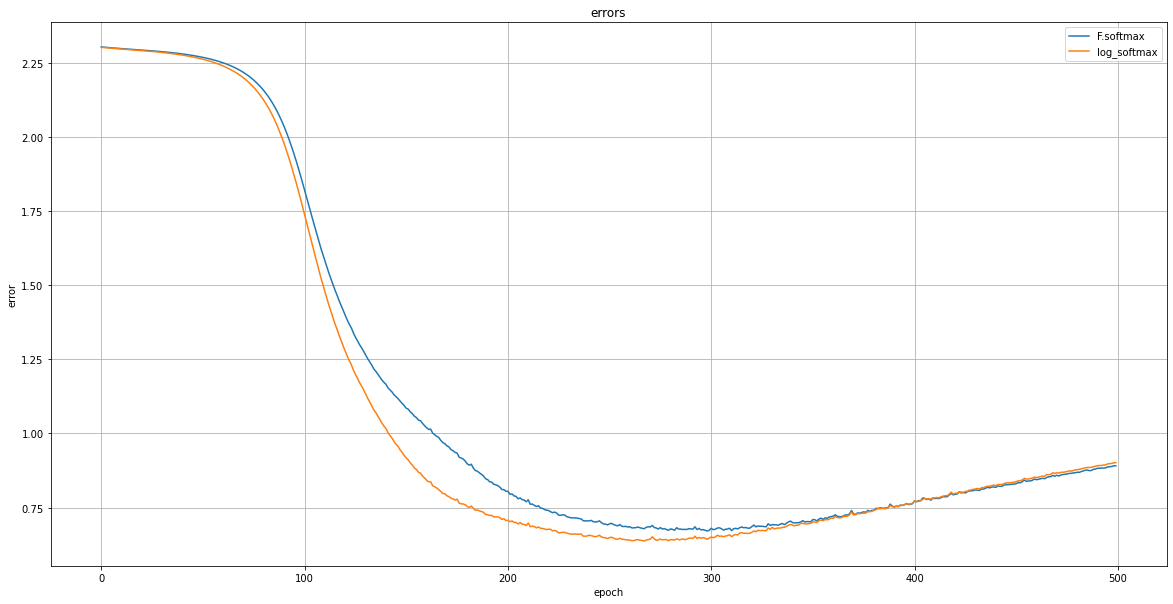

In [16]:
from pylab import rcParams
rcParams['figure.figsize'] = 20, 10
plot_graphs(test_log, 'loss')

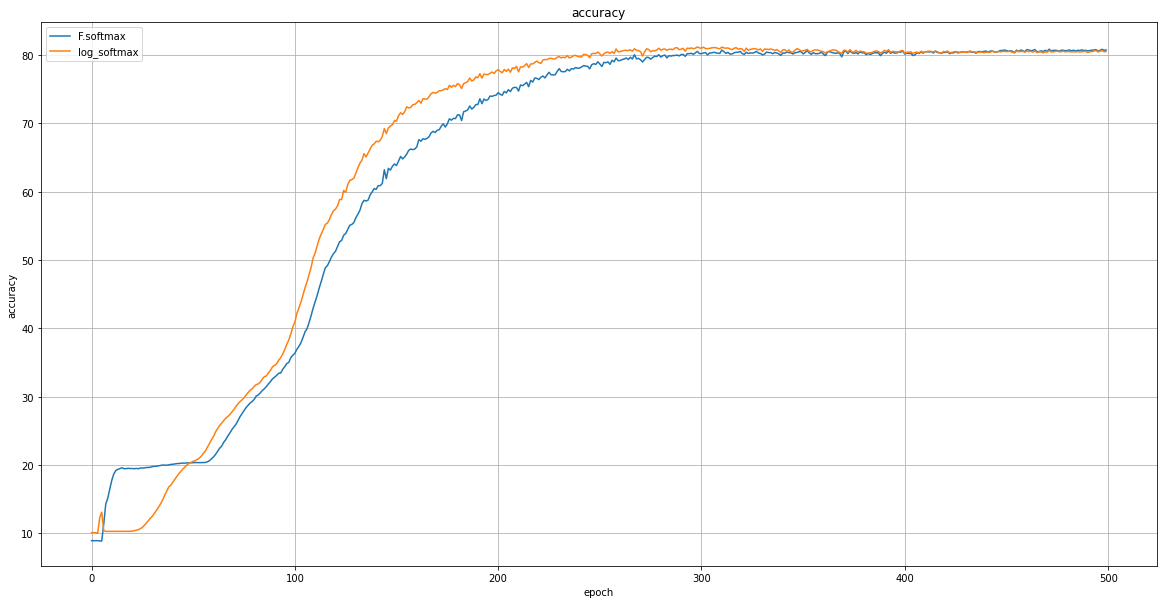

In [17]:
plot_graphs(test_log, 'accuracy')

In [11]:
test_log

{'F.softmax': [(2.304551475071907, tensor(8.9200)),
  (2.303847157692909, tensor(8.9200)),
  (2.303181861424446, tensor(8.9200)),
  (2.3025501314640047, tensor(8.9200)),
  (2.301946649646759, tensor(8.8900)),
  (2.3013658689022063, tensor(8.8600)),
  (2.3008060288906096, tensor(11.3800)),
  (2.300259348535538, tensor(14.3000)),
  (2.2997272054195403, tensor(15.1600)),
  (2.299208303928375, tensor(16.5400)),
  (2.298701072525978, tensor(17.8100)),
  (2.2982047543764113, tensor(18.7200)),
  (2.297715859556198, tensor(19.2100)),
  (2.297231854367256, tensor(19.3600)),
  (2.2967528824567793, tensor(19.4800)),
  (2.2962812967538833, tensor(19.5900)),
  (2.2958118710517885, tensor(19.4500)),
  (2.295340613102913, tensor(19.4600)),
  (2.2948691939353942, tensor(19.5100)),
  (2.294390573835373, tensor(19.4800)),
  (2.2939018749475477, tensor(19.4800)),
  (2.293406449460983, tensor(19.4500)),
  (2.2929005105495452, tensor(19.5000)),
  (2.2923816130399706, tensor(19.4400)),
  (2.291855415225029,